# Sales Prediction using Sales, Inventory and Item Attributes
***
### Can you predict this week's sales from Sales History, Inventory and Item Attributes?

A valuable exercise in retail is being able to predict sales of your inventory. Predictive models can be used to do this, building a relationship betwen given information that you have currently and future sales. Current information includes previous sales, inventory and item attributes, and there is no shortage of this.

The many item attributes are recorded when the new SKU's are entered by hand one by one, or loaded as a group by uploading them and processing them into the inventory. They are stored in the Inventory Master file (INVMST) in JDA, a retail ERP. Sales history is built as stores sell inventory. Quantities and prices are uploaded from the Point-Of-Sale and accumulated into a few buckets in the Inventory Balance files (INVBAL and INVCBL). 

The data used for this exercise is directly pulled out of JDA's Merchandise Management System, which runs on IBM's System-i, with DB2/400 as the database. The information is downloaded from INVMST, INVCBL and INVBAL (limited to only stores between 1001 and 1003).

**Independent variables**
	
1. Chain Inventory
2. Store Inventory for primary stores selling subset of product
3. Chain YTD Sales
4. Store YTD Sales for primary stores selling subset of product
5. Item Attributes, including top words in Item Description.

**Target variable**

Sales Current Week (IBWK01): numeric value representing sales this week. 

In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from string import punctuation
import string
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn import model_selection
from math import sqrt

%matplotlib inline

## Read in Data from JDA

### Item Master:

In [2]:
item_master = pd.read_csv("data/INVMST - Item Master.csv", encoding = "ISO-8859-1")
print(item_master.head())
#item_master.dtypes

/home/ubuntu/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (9,16,28,29,32,65,68,69,79,80,82,88) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


   INUMBR  ICHECK                       IDESCR IDSCCD       ISORT  ISTYLN  \
0   10000       5  **SOUVENIR CATCHALL-AUTHOR.      I  **SOUVENIR     NaN   
1   32588       0            JUNIOR BRIDESMAID      I  JUNIOR BRI     NaN   
2   32591       0  KNLNG.GIRL AT CHURCH WINDOW      I  KNLNG.GIRL     NaN   
3   32593       7    TWO GIRLS HOLDING FLOWERS      I   TWO GIRLS     NaN   
4   32599       6           MOTHER WITH BABIES      I  MOTHER WIT     NaN   

   ASNUM      IVNDPN  IMFGR IMFGNO  ...  IPRCCH  IPRCZN  IPRCST  IASNUM  \
0    995  AUTHORIZED      0    NaN  ...       R       N       N       0   
1  37125       E2845      0    NaN  ...       B       N       P       0   
2  37125      100064      0    NaN  ...       B       N       P       0   
3  37125      100072      0    NaN  ...       B       N       P       0   
4  37125      100137      0    NaN  ...       B       N       P       0   

   ICORGP  ILEAD IHZCOD IFRACT  IMCRDT  IMCRCN  
0    ASST      0    NaN    NaN       

### Chain Inventory Balance (INVCBL):

In [3]:
inv_bal_chain = pd.read_csv("data/INVCBL - Chain Level Inventory Balance Data.csv", encoding = "ISO-8859-1")
print(inv_bal_chain.head())
#inv_bal_chain.dtypes

   INUMBR  CBHBOY  CBHBOP  CBHAND  CBTRNS  CBGMRI  CBWKCR  CBWK01  CBWK02  \
0       0       0     0.0     0.0       0       0       0       0       0   
1       1       0     0.0     0.0       0       0       0       0       0   
2       2       0     0.0     0.0       0       0       0       0       0   
3       4       0     0.0     0.0       0       0       0       0       0   
4      12      33     7.0     6.0       0       0       0       1       0   

   CBWK03  ...  CBNSQT  CBHLDQ  CBTSCN  CBTSDT  CBTRCN  CBTRDT  CBCEN2  \
0       0  ...       0       0       0       0       0       0       0   
1       0  ...       0       0       1  130828       1   80114       0   
2       0  ...       0       0       0       0       1  140403       0   
3       0  ...       0       0       1  100111       1   80918       0   
4       0  ...       0       0       1  151201       1  151202       1   

   CBALD2  CBFRCN  CBFRDT  
0       0       0       0  
1       0       0       0  
2       

### Inventory Balance by Store (INVBAL):

In [4]:
inv_bal_store = pd.read_csv("data/INVBAL - Store Level Inventory Balance Data - Niquea'D.csv", encoding = "ISO-8859-1")
print(inv_bal_store.head())
#inv_bal_store.dtypes

   INUMBR  ISTORE  IBHBOY  IBHBOP  IBHAND  IBTRNS  IBGMRI  IBWKCR  IBWK01  \
0      12    1001       0      -2      -2       0       0       0       0   
1      24    1001       0       0       0       0       0       0       0   
2     175    1001       0       0       0       0       0       0       0   
3     231    1001       0       0       0       0       0       0       0   
4     900    1001       0       0       0       0       0       0       0   

   IBWK02  ...  IBLAVC  IBARQT  IBNSQT  IBPHND  IBHLDQ  IBCRCD  IBTSCN  \
0       0  ...  0.0000       0       0       0       0     NaN       0   
1       0  ...  0.0000       0       0       0       0     NaN       0   
2       0  ...  0.2508       0       0       0       0     NaN       0   
3       0  ...  0.2925       0       0       0       0     NaN       0   
4       0  ...  0.0000       0       0       0       0     NaN       0   

   IBTSDT  IBTRCN  IBTRDT  
0       0       0       0  
1       0       0       0  
2       

## Data Preparation

### Chain Sales YTD = Regular Sales + Ad Sales

In [5]:
inv_bal_chain["chn_sales"] = inv_bal_chain["CBRSUY"]+inv_bal_chain["CBASUY"]
inv_bal_chain.head()

,INUMBR,CBHBOY,CBHBOP,CBHAND,CBTRNS,CBGMRI,CBWKCR,CBWK01,CBWK02,CBWK03,...,CBHLDQ,CBTSCN,CBTSDT,CBTRCN,CBTRDT,CBCEN2,CBALD2,CBFRCN,CBFRDT,chn_sales
0,0,0,0.0,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0.0,0.0,0,0,0,0,0,0,...,0,1,130828,1,80114,0,0,0,0,0
2,2,0,0.0,0.0,0,0,0,0,0,0,...,0,0,0,1,140403,0,0,0,0,0
3,4,0,0.0,0.0,0,0,0,0,0,0,...,0,1,100111,1,80918,0,0,0,0,0
4,12,33,7.0,6.0,0,0,0,1,0,0,...,0,1,151201,1,151202,1,150716,1,130606,28


### Sum up Sales, Inventory by SKU (INUMBR)

In [6]:
inv_bal_store_sum=inv_bal_store.groupby('INUMBR')['IBRSUY','IBASUY','IBHAND','IBWKCR','IBWK01','IBWK02','IBWK03','IBWK04','IBWK05','IBWK06','IBWK07','IBWK08'].sum()
inv_bal_store_sum.head()

,IBRSUY,IBASUY,IBHAND,IBWKCR,IBWK01,IBWK02,IBWK03,IBWK04,IBWK05,IBWK06,IBWK07,IBWK08
INUMBR,,,,,,,,,,,,
12,2,0,-2,0,0,0,0,0,0,0,2,0
24,0,0,0,0,0,0,0,0,0,0,0,0
175,0,0,0,0,0,0,0,0,0,0,0,0
200,0,0,0,0,0,0,0,0,0,0,0,0
231,0,0,0,0,0,0,0,0,0,0,0,0


### Store Sales YTD = Regular Sales + Ad Sales
Also, remove records without any sales or inventory

In [7]:
inv_bal_store_sum['nd_sales']=inv_bal_store_sum['IBRSUY']+inv_bal_store_sum['IBASUY']
inv_bal_store_sum = inv_bal_store_sum[(inv_bal_store_sum['IBHAND']!=0) | (inv_bal_store_sum['nd_sales']!=0)]
inv_bal_store_sum.shape

(18493, 13)

### Join Store (3 stores) sales, inventory with Chain sales, inventory

In [8]:
inv_final = pd.merge(inv_bal_store_sum,inv_bal_chain,on='INUMBR', how='left')
inv_final.head()

,INUMBR,IBRSUY,IBASUY,IBHAND,IBWKCR,IBWK01,IBWK02,IBWK03,IBWK04,IBWK05,...,CBHLDQ,CBTSCN,CBTSDT,CBTRCN,CBTRDT,CBCEN2,CBALD2,CBFRCN,CBFRDT,chn_sales
0,12,2,0,-2,0,0,0,0,0,0,...,0.0,1.0,151201.0,1.0,151202.0,1.0,150716.0,1.0,130606.0,28.0
1,18002,11,0,5,4,2,0,0,0,0,...,0.0,1.0,151212.0,1.0,151215.0,1.0,151214.0,1.0,91019.0,4164.0
2,18015,2,0,0,0,0,0,0,0,0,...,0.0,1.0,150303.0,1.0,150304.0,1.0,140427.0,1.0,91019.0,200.0
3,64645,6,0,0,0,0,0,0,0,0,...,0.0,1.0,150810.0,1.0,150811.0,1.0,140825.0,1.0,91019.0,1118.0
4,72593,1,0,-1,0,0,0,0,0,0,...,0.0,0.0,0.0,1.0,90930.0,0.0,0.0,0.0,0.0,1.0


### Reorder, drop redundant, unneeded fields

In [9]:
inv_final = inv_final[['INUMBR','nd_sales','chn_sales','IBHAND','IBWKCR','IBWK01','IBWK02','IBWK03','IBWK04','IBWK05','IBWK06','IBWK07','IBWK08']]
inv_final.head()

,INUMBR,nd_sales,chn_sales,IBHAND,IBWKCR,IBWK01,IBWK02,IBWK03,IBWK04,IBWK05,IBWK06,IBWK07,IBWK08
0,12,2,28.0,-2,0,0,0,0,0,0,0,2,0
1,18002,11,4164.0,5,4,2,0,0,0,0,0,0,1
2,18015,2,200.0,0,0,0,0,0,0,0,0,0,0
3,64645,6,1118.0,0,0,0,0,0,0,0,0,0,0
4,72593,1,1.0,-1,0,0,0,0,0,0,0,0,0


### Join Item Master detail (INVMST) to Sales, Inventory

In [10]:
inv_final = pd.merge(inv_final, item_master, on='INUMBR', how='left')
print(inv_final.shape)
inv_final.head()

(18493, 106)


,INUMBR,nd_sales,chn_sales,IBHAND,IBWKCR,IBWK01,IBWK02,IBWK03,IBWK04,IBWK05,...,IPRCCH,IPRCZN,IPRCST,IASNUM,ICORGP,ILEAD,IHZCOD,IFRACT,IMCRDT,IMCRCN
0,12,2,28.0,-2,0,0,0,0,0,0,...,R,N,N,0,NaN,0,NaN,NaN,90925,1
1,18002,11,4164.0,5,4,2,0,0,0,0,...,R,N,P,0,NaN,0,NaN,NaN,90805,1
2,18015,2,200.0,0,0,0,0,0,0,0,...,R,N,P,0,NaN,0,NaN,NaN,90805,1
3,64645,6,1118.0,0,0,0,0,0,0,0,...,R,N,P,0,NaN,0,NaN,NaN,90805,1
4,72593,1,1.0,-1,0,0,0,0,0,0,...,R,N,P,0,NaN,0,NaN,NaN,90805,1


## Natural Language Processing on Item Description

### Isolate Description field

In [11]:
inv_final_desc = inv_final['IDESCR']

### Clean up Description: 

In [12]:
# Create a list of punctuation replacements
punctuation_symbols = []
for symbol in punctuation:
    punctuation_symbols.append((symbol, ''))

# Extract list of Stop words
stop = stopwords.words('english')

In [13]:
# Create a function to remove punctuations
#def remove_punctuation(sentence: str) -> str:
#    return sentence.translate(str.maketrans('', '', string.punctuation))

# Create a function to remove stop words
def remove_stop_words(x):
    x = ' '.join([i for i in x.split(' ') if i not in stop])
    return x

# Create a function to lowercase the words
def to_lower(x):
    return x.lower()

In [14]:
porter = PorterStemmer()

inv_final_desc = inv_final_desc.apply(porter.stem)
#inv_final_desc = inv_final_desc.apply(remove_punctuation)
inv_final_desc = inv_final_desc.apply(remove_stop_words)
inv_final_desc = inv_final_desc.apply(to_lower)

### Create one-hot encoded sparse matrix of top words

Any words appearing at least 100 times gives 63 top words.

In [15]:
cv = CountVectorizer(min_df=100)
descriptions_cv = cv.fit_transform(inv_final_desc)

print("Item Description Shape: " + str(descriptions_cv.shape))

descriptions_vectors = pd.DataFrame(descriptions_cv.todense(), columns=cv.get_feature_names())
print(descriptions_vectors.head())

Item Description Shape: (18493, 72)
   2016  baby  bag  bd  bdy  bg  bird  birthday  bk  black  ...  text  thank  \
0     0     0    0   0    0   0     0         0   0      0  ...     0      1   
1     0     0    0   0    0   0     0         0   0      0  ...     0      0   
2     0     0    0   0    0   0     0         0   0      0  ...     0      0   
3     0     0    0   0    0   0     0         0   0      0  ...     0      0   
4     0     0    0   0    0   0     0         0   0      0  ...     0      0   

   tray  tre  ty  vintage  wed  white  wht  xbc  
0     0    0   0        0    0      0    0    0  
1     0    0   0        0    0      0    0    0  
2     0    0   0        0    0      0    0    0  
3     0    0   0        0    0      0    0    0  
4     0    0   0        0    0      0    0    0  

[5 rows x 72 columns]


### Drop static or missing content from Item Attributes (std=zero or whole column is N/A)

In [16]:
inv_final.drop(inv_final.std()[inv_final.std() == 0].index.values, axis=1, inplace=True)
inv_final=inv_final.dropna(axis=1,how='all')

inv_final.shape

(18493, 76)

### Search for missing numeric values and fill with Zeros

In [17]:
inv_final.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
INUMBR,18493.0,735006.621370,60825.921368,12.0,703204.0,740428.0,775814.0,1009366.0
nd_sales,18493.0,4.962256,12.440917,-2.0,1.0,3.0,6.0,930.0
chn_sales,18485.0,795.342602,1656.512124,-5.0,7.0,212.0,1059.0,91973.0
IBHAND,18493.0,5.188179,19.353446,-936.0,0.0,2.0,6.0,1031.0
IBWKCR,18493.0,0.212513,0.887606,-2.0,0.0,0.0,0.0,42.0
IBWK01,18493.0,0.241335,1.323916,-1.0,0.0,0.0,0.0,128.0
IBWK02,18493.0,0.161304,0.697320,-1.0,0.0,0.0,0.0,31.0
IBWK03,18493.0,0.107500,0.549137,-1.0,0.0,0.0,0.0,20.0
IBWK04,18493.0,0.129833,0.720639,-6.0,0.0,0.0,0.0,42.0
IBWK05,18493.0,0.119883,0.535725,-1.0,0.0,0.0,0.0,17.0


In [18]:
inv_final['BYRNUM'].fillna(0, inplace=True)
inv_final['ITKTTR'].fillna(0, inplace=True)
inv_final['ILBLTR'].fillna(0, inplace=True)
inv_final['IRPLCD'].fillna(0, inplace=True)
inv_final['IDISTM'].fillna(0, inplace=True)
inv_final['IWARNT'].fillna(2, inplace=True)
inv_final['ITKTTA'].fillna(0, inplace=True)
inv_final['chn_sales'].fillna(0, inplace=True)

### Drop columns with 2 or less unique values

In [19]:
inv_final.drop(inv_final.columns[inv_final.count()<=2], axis=1, inplace=True)
inv_final.drop(['IWARNT'], axis=1, inplace=True)

### Drop object/string column if unique values is too many, losing meaning to model

In [20]:
for column in inv_final.select_dtypes(include=['object']).columns:
    print(column, inv_final[column].unique().size)

IDESCR 17265
IDSCCD 2
ISORT 9478
IVNDPN 11454
IMFGNO 181
IBUYCD 2
IPRMPT 2
IPRVNT 2
IFINLN 9
IPROFL 3
IMODUL 2
ISTYPE 6
ISLUM 2
IBYUM 1
IHLDOR 3
IHLDWO 1
ISEASN 19
IATRB3 34
IATRB4 3
IATRB5 2
IPRCCH 3
IPRCZN 1
IPRCST 4
ICORGP 9


In [21]:
inv_final.drop(['IDESCR',], axis=1, inplace=True)
inv_final.drop(['ISORT',], axis=1, inplace=True)
inv_final.drop(['IVNDPN',], axis=1, inplace=True)
inv_final.drop(['IMFGNO',], axis=1, inplace=True)

### For columns <5 unique values, drop if too unbalanced.

In [22]:
for column in inv_final.select_dtypes(include=['object']).columns:
    if inv_final[column].unique().size < 5:
        print(inv_final.groupby(column).size(),'\n')

IDSCCD
A    18456
I       37
dtype: int64 

IBUYCD
C    18473
S       20
dtype: int64 

IPRMPT
N    18483
dtype: int64 

IPRVNT
N    18492
Y        1
dtype: int64 

IPROFL
FLAT     78
LEPEN     8
dtype: int64 

IMODUL
A    21
dtype: int64 

ISLUM
001       24
EA     18469
dtype: int64 

IBYUM
EA    18493
dtype: int64 

IHLDOR
N    13305
Y        1
dtype: int64 

IHLDWO
N    18493
dtype: int64 

IATRB4
0.0    6699
1.0       2
dtype: int64 

IATRB5
N    18477
dtype: int64 

IPRCCH
B       65
N       39
R    18389
dtype: int64 

IPRCZN
N    18493
dtype: int64 

IPRCST
B     245
N    9554
P    7496
R    1198
dtype: int64 



In [23]:
inv_final.drop(['IDSCCD',], axis=1, inplace=True)
inv_final.drop(['IPRMPT',], axis=1, inplace=True)
inv_final.drop(['IPRVNT',], axis=1, inplace=True)
inv_final.drop(['IMODUL',], axis=1, inplace=True)
inv_final.drop(['ISLUM',], axis=1, inplace=True)
inv_final.drop(['IBYUM',], axis=1, inplace=True)
inv_final.drop(['IHLDOR',], axis=1, inplace=True)
inv_final.drop(['IHLDWO',], axis=1, inplace=True)
inv_final.drop(['IATRB4',], axis=1, inplace=True)
inv_final.drop(['IATRB5',], axis=1, inplace=True)
inv_final.drop(['IPRCZN',], axis=1, inplace=True)

### For object/string columns fill N/A values with space

In [24]:
for column in inv_final.select_dtypes(include=['object']).columns:
    inv_final[column].fillna(' ', inplace=True)
    
print(inv_final.shape)
inv_final.dtypes[inv_final.dtypes==object]

(18493, 57)


IBUYCD    object
IFINLN    object
IPROFL    object
ISTYPE    object
ISEASN    object
IATRB3    object
IPRCCH    object
IPRCST    object
ICORGP    object
dtype: object

### Convert object/string columns to numeric using Label Encoding

In [25]:
le = LabelEncoder()
for column in inv_final.select_dtypes(include=['object']).columns:
    inv_final[column] = le.fit_transform(inv_final[column])

print(inv_final.shape)

(18493, 57)


### Create Heatmap showing Correlated columns

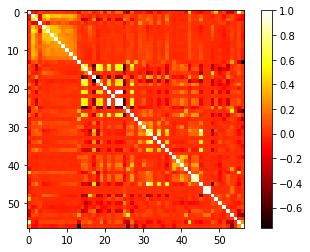

In [26]:
corr = inv_final.corr()

plt.imshow(corr, cmap='hot', interpolation='nearest')
plt.colorbar()

## Initial Modeling using Linear Regression

### Create base model using only Sales as a function of Inventory and Sales History
R2 = 0.323

In [27]:
X = inv_final[['IBHAND', 'IBWK02', 'IBWK03', 'IBWK04', 'IBWK05', 'IBWK06', 'IBWK07', 'IBWK08']]
y = inv_final['IBWK01']

In [28]:
lm = LinearRegression()
lm.fit(X, y)

print(lm.intercept_)
print(lm.coef_)

y_pred = lm.predict(X)
r2_score(y,y_pred)

0.07263919173846103
[-0.01264186  0.38619785  0.48719217  0.36681299  0.06144283  0.32152532
  0.32145227  0.03547413]


0.32339055929306904

### Predict Sales on all columns minus description vectors
R2 = 0.469

In [29]:
X = inv_final.drop('IBWK01', axis=1)
y = inv_final['IBWK01']

In [30]:
lm = LinearRegression()
lm.fit(X, y)

print(lm.intercept_)
print(lm.coef_)

y_pred = lm.predict(X)
r2_score(y,y_pred)

-1.627504608644098
[-3.87679319e-06  1.74832251e-02  1.60069854e-04 -6.25347703e-03
  3.72221598e-01  1.85725490e-01  2.60310030e-01  2.14854615e-01
 -2.98000629e-02  1.67098473e-01  1.24663224e-01 -2.00567020e-02
 -1.81339929e-01  2.24125789e-07  8.85519486e-04  1.06253291e-03
  3.11432721e-05 -5.58504994e-04 -2.39553007e-02 -1.74934568e+00
  4.72821483e-01  1.27300773e-01  4.90480127e-01 -9.90631182e-01
 -6.69281453e-02 -5.76437799e-01  4.69429045e-02  1.23277008e+00
  1.89305876e-03 -1.67917229e-04 -1.33942197e-03  8.84390862e-04
  5.48041780e-02  8.78936999e-03  9.09226878e-02 -9.92953041e-02
  1.91974010e-04  1.80743665e-04 -1.66165660e-04 -9.19951351e-03
 -7.03398305e-03  7.78303521e-07 -1.08977650e-03 -2.21120707e-02
 -2.64092166e-02 -1.40864753e-10 -1.12963894e-05  1.81028041e-02
  9.27248364e-02  2.99067529e-04  1.37499429e-01 -6.82829197e-02
  2.29276421e-01 -1.46247724e-04  1.72784544e-05  1.54209267e+00]


0.4694299913178033

### Add description vectors, do Linear Regression again
R2 = 0.472

In [31]:
X = pd.concat([inv_final, descriptions_vectors], axis=1).drop('IBWK01', axis=1)
y = inv_final['IBWK01']

In [32]:
lm = LinearRegression()
lm.fit(X, y)

print(lm.intercept_)
print(lm.coef_)

y_pred = lm.predict(X)
r2_score(y,y_pred)

-1.6173063057630466
[-3.82633479e-06  1.74996170e-02  1.63246973e-04 -6.19937124e-03
  3.68479568e-01  1.85089776e-01  2.59215383e-01  2.13909629e-01
 -2.82230130e-02  1.66610371e-01  1.24595858e-01 -1.97072101e-02
 -1.76629591e-01  2.16279662e-07  8.99298902e-04  4.57813934e-04
 -2.68728144e-04 -7.52061022e-04 -2.50772388e-02 -1.76826222e+00
  4.97796244e-01  1.44664973e-01  5.52206396e-01 -1.08182403e+00
 -7.63491624e-02 -5.89189183e-01  4.53753259e-02  1.22372113e+00
  1.81407615e-03 -1.92165642e-04 -3.03459982e-02  9.40995502e-04
  6.82713771e-02  7.11364411e-03  9.23228637e-02 -9.80910537e-02
  7.02645375e-05  1.82301801e-04 -1.52676777e-04 -8.70152744e-03
 -7.13628332e-03  6.13041493e-07 -1.27700938e-03 -1.95889994e-02
 -1.10147012e-02 -1.40149531e-10 -1.12359462e-05  1.82622477e-02
  8.79441430e-02 -1.86904543e-05  1.32663050e-01 -6.93695381e-02
  2.39744813e-01 -1.52995251e-04  1.72658071e-05  1.57142626e+00
  1.47375076e-02 -4.41967858e-03 -1.08326275e-01 -1.43305224e-02
  1.1

0.4731338543541357

## Split Training and Test, do model progression comparison
### First, Linear Regression
RMSE = 1.25 Units

In [33]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X,y,test_size=0.3,random_state=42)

In [34]:
lm = LinearRegression()
lm.fit(X_train, y_train)

y_pred = lm.predict(X_test)
print(sqrt(mean_squared_error(y_pred, y_test)))

1.2475211210842712


### Second, Decision Tree
RMSE = 0.978 Units

In [35]:
dt = tree.DecisionTreeRegressor()
dt.fit(X_train, y_train)

y_pred = dt.predict(X_test)
print(sqrt(mean_squared_error(y_pred, y_test)))

1.9884761731003324


### Third, Random Forest
RMSE = 0.818 Units

In [36]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
print(sqrt(mean_squared_error(y_pred, y_test)))

/home/ubuntu/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


1.1610306064932705


### Fourth, XGBoost (100 estimators)
RMSE = 0.852 Units
 - Worse!

In [37]:
xgb = XGBClassifier(n_estimators=100)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [38]:
y_pred = xgb.predict(X_test)
print(sqrt(mean_squared_error(y_pred, y_test)))

0.8470866992175878


### Fifth, XGBoost with KFold cross-validation
RMSE = 0.882
- Worse, but on less training data

In [42]:
seed = 42
num_trees = 100

kfold = model_selection.KFold(n_splits=10, random_state=seed)
xgk = XGBClassifier(n_estimators=num_trees, random_state=seed)
results = model_selection.cross_val_score(xgk, X, y, cv=kfold)
print(results)
print(results.mean())

[0.91837838 0.97081081 0.91459459 0.9621417  0.92536506 0.91400757
 0.81936182 0.89994592 0.81016766 0.69010276]
0.8824876266206715


### Sixth, XGBoost with Grid Search (Time To Get Serious!)
Best RMSE = 


In [39]:
xgb = XGBClassifier()

xgboost_grid = {"max_depth": [3,4,5], #tried 1, 2
              "max_features" : [0.5,0.7,1.0], #tried 1.5
              "min_samples_leaf" : [1,2], #tried 3, 5
              "n_estimators": [110, 120, 130], #tried 90, 100
              "learning_rate": [0.1]} #tried 0.02, 0.05, 0.2

xgboost_gridsearch = GridSearchCV(estimator = xgb, 
                          param_grid=xgboost_grid, 
                          cv = 3, 
                          n_jobs = -1, 
                          verbose = 1)

xgboost_gridsearch.fit(X_train, y_train)

print('XGboost model:\n{}\n'.format(xgboost_gridsearch.best_params_))
predictions_xgb = xgboost_gridsearch.predict(X_test)
print('XGBoost RMSE score: ', sqrt(mean_squared_error(predictions_xgb, y_test)))


Fitting 3 folds for each of 54 candidates, totalling 162 fits


/home/ubuntu/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed: 34.5min finished


XGboost model:
{'learning_rate': 0.1, 'max_depth': 3, 'max_features': 0.5, 'min_samples_leaf': 1, 'n_estimators': 120}

XGBoost RMSE score:  0.8538685873878706


### XGBoost with best parameters:

In [40]:
xgb = XGBClassifier(n_estimators=120, min_samples_leaf=1, max_features=0.5)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              max_features=0.5, min_child_weight=1, min_samples_leaf=1,
              missing=None, n_estimators=120, n_jobs=1, nthread=None,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=1, verbosity=1)

In [41]:
y_pred = xgb.predict(X_test)
print(sqrt(mean_squared_error(y_pred, y_test)))

0.8538685873878706
